# Research on SP Wholesale Plan

## Motivation

Living in Singapore is expensive. Being a family guy (and sole breadwinner!), I'm always trying to find deals to help me save whatever I can for our next holiday or retirement. Since 1 Nov 2018, I've been allowed to switch to be a contestible customer so this is my next chance at changing something to save for the household. 

Since I also have an AMI meter already, it makes sense for me to see if a half-hourly floating price plan like SP Wholesale plan can offer me a better deal. 

Here's some on the SP Wholesale plan and why I think its a better deal than what other retailers are offering.

In [1]:
%matplotlib inline
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## What my household's half-hourly electricity usage look like...
I'll start off by trying to understand my usage patterns. Unfortunately there's no simpler way of getting this other than opening the SP Utilities app and manually recording the half-hourly readings on an Excel sheet. I managed 5 random days (thats 48 x 5 times looking at monitor screen, keyboard and swiping handphone back-to-back!). Let's start with this for now.

In [2]:
# read my 30-min electricity data
elect_usages = pd.read_csv("./data/luq_household_elect_usage.csv")

# insert time component
date = datetime.strptime("1970-01-01 00:00", "%Y-%m-%d %H:%M")
time_ = [(date + timedelta(minutes=i*30)).time() for i in range(48)]
elect_usages["time_"] = time_

# make time the index
elect_usages = elect_usages.set_index("time_")

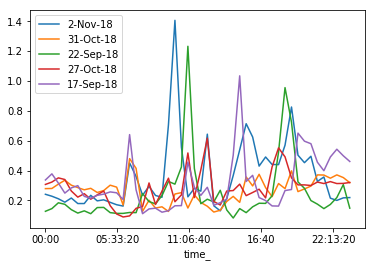

In [3]:
_ = elect_usages.plot()

Looks pretty consistent and normal even though there are periods with single spike, but no big deal - these lone spikes truly reflects the unique variation of the usage pattern of each day.

Let's fish out some basic stats from these 5 random days.

In [4]:
# Get to know my basic usage stats
total_usage = elect_usages.sum()
average_usage = np.average(total_usage)
print("Respective total usage from 5 dates (KwH): \n{}".format(total_usage))
print("\n")
print("Average daily usage: \n{}".format(average_usage))
print("\n")
print("Monthly usage: \n{}".format(average_usage*30))

Respective total usage from 5 dates (KwH): 
2-Nov-18     17.4088
31-Oct-18    12.8627
22-Sep-18    11.8118
27-Oct-18    13.6248
17-Sep-18    15.4098
dtype: float64


Average daily usage: 
14.223579999999998


Monthly usage: 
426.70739999999995


## Rates comparison
Apparently my usage stats above will come in handy when I'm searching for the cheapest electricity provider. There are 2 websites dedicated to giving you the cheapest deal:
1. https://compare.openelectricitymarket.sg/
2. https://battleroyal.apps.spdigital.io

We'll use `Open Electricity Market` to do our search since they are updated and gives _Standard_ rates; these rates have all charges in with no other hidden charges i.e. the rate you see is what you pay.

Unfortunately, `Battle Royal` isn't really updated and do not specify if the plan offered are standard or not. 

So according to the OEM's comparison website, based on my usage these are best `Discount off tariff` and `Fixed-rate` plans (_I've included the current SP tariff rates for comparison._)

In [5]:
# all rates are per kwh
sp_tariff = 0.2582
best_disct_on_tariff = (100-23)/100*sp_tariff # 23% discount on tariff
best_fixed = 0.1798

print("SP tariff rate: ${}".format(sp_tariff))
print("Best Discount-off tariff rate: ${}".format(best_disct_on_tariff))
print("Best Fixed rate: ${}".format(best_fixed))

SP tariff rate: $0.2582
Best Discount-off tariff rate: $0.198814
Best Fixed rate: $0.1798


Our best rate is hence the minimum of these values...

In [6]:
best_deal = min(sp_tariff, best_disct_on_tariff, best_fixed)

## What about SP Wholesale Plan?

The SP Wholesale plan is not widely known or advertised. When you do eventually find the link to the document to know more about the plan, the additional charges can be quite cryptic and technical. The document itself reads like its trying to tell you something -- __"Stay Away!"__

Even calculating your base charges (not even the full charges yet!) is something a math PhD will write:

![](./img/how_to_calculate_energy_usage.png)
(_Source:_ https://www.ema.gov.sg/cmsmedia/PPD/MSS%20Code%20-%20June%202018.pdf. 
_Refer to Clause 6.1 of this link if you want to know more_)

SP Wholesale plan is a floating 30-min rate largely based off USEP prices which changes every half-hour. Other variable prices include:
1. Ancilliary services (_based on the formula above_)
2. Vesting contract debit (variable)
3. Off-peak period charge (\$0.0399 per kWh) - 12am to 6.30am\*
4. Peak period charge (\$0.0531 per kWh) - 7am to 11.30pm\*
5. Meter Reading and Data Management (\$2.1800 per meter)
6. Market Development and Systems Charge (\$0.0040 per kWh)
7. Retail Settlement Uplift (\$0.0011 per kWh)

All these charges and technicalities lead to a mental load when presented to a lay person and might deter anyone from ever considering to apply. Luckily, I'm quite technical and I can thank my wife and 3 boys for training my mental load!

(3)-(7) have straightforward prices given by SP. The calculation in (1) and USEP price are surprisingly easy to find in the emcsg.com website - I just pull out the Wholesale Clectricity Prices and remove the PSO and EMC components while ignoring the transmission losses. 

The tricky one is (2) - to know if you're debited or credited, you have to know the energy usage and price and see if its above/below the hedge price. There is no easy way to find this out so I assume this value to be $0.01 throughout this exercise.

### So is it cheaper ? Let's see...

First we need to load the wholesale price, perform the calculation above and add a few more features along the way to give us the final `wholesale_charge` column.

In [7]:
from glob import glob

# 2018's Wholesale Prices
wholesale_prices = pd.DataFrame()
for i in glob("./wholesale_prices/*"):
    tmpdf = pd.read_csv(i)
    
    # format date and time
    tmpdf["DATE"] = tmpdf["DATE"].apply(lambda x: datetime.strptime(x, "%d %b %Y"))
    tmpdf["dt"] = tmpdf.apply(lambda x: (x.DATE + timedelta(minutes=(x.PERIOD*30)-30)), axis=1)
    tmpdf["month"] = tmpdf.dt.apply(lambda x: x.month)
    tmpdf["year"] = tmpdf.dt.apply(lambda x: x.year)    
    tmpdf["day"] = tmpdf.dt.apply(lambda x: x.day)
    tmpdf["time_"] = tmpdf.dt.apply(lambda x: x.time())    
    tmpdf["hour"] = tmpdf.dt.apply(lambda x: x.hour)    

    
    # 1a. We can adjust the our prices on components which we don't need.
    tmpdf["WEP_rate_per_MWH_adj"] = tmpdf.apply(lambda x: x['WEP ($/MWh)'] - (x['PSO Fees ($/MWh)'] + 
                                                                              x['EMC Price Cap Fees ($/MWh)'] +
                                                                              x['EMC Price Adj Fees ($/MWh)']),
                                                                             axis=1)

#     # 1b. Based on SP Customer Service officer
#     tmpdf["WEP_rate_per_MWH_adj"] = tmpdf.apply(lambda x: x['USEP ($/MWh)'] + (x['AFP ($/MWh)'] + 
#                                                                               x['HEUR ($/MWh)'] +
#                                                                               x['HLCU ($/MWh)'] +
#                                                                               x['MEUC ($/MWh)']),
#                                                                              axis=1)

    # 3. adjust it to kwh
    tmpdf["WEP_rate_per_KWH_adj"] = tmpdf["WEP_rate_per_MWH_adj"]/1000
    
    # 4. add vesting contract charges per KwH
    tmpdf["vesting_contract"] = 0.01

    # 5. peak/off-peak period charge per KwH
    tmpdf["period_charge"] = tmpdf.apply(lambda x: 0.0399 if 0<= x.hour <7 else 0.0531, axis=1)
    
    # 6. add MSSL charges per KwH
    tmpdf["market_devel"] = 0.004
    
    # 7. add Retail uplift per KwH
    tmpdf["uplift"] = 0.0011

    tmpdf["wholesale_charge"] = tmpdf["WEP_rate_per_KWH_adj"] + tmpdf["vesting_contract"] + \
                                tmpdf["period_charge"] + tmpdf["market_devel"] + tmpdf["uplift"]
        
    wholesale_prices = wholesale_prices.append(tmpdf)

Here's what the final dataframe looks like -- 

In [8]:
wholesale_prices.head(5)

,INFORMATION TYPE,DATE,PERIOD,WEP ($/MWh),USEP ($/MWh),AFP ($/MWh),HEUR ($/MWh),HLCU ($/MWh),MEUC ($/MWh),EMC Price Cap Fees ($/MWh),...,day,time_,hour,WEP_rate_per_MWH_adj,WEP_rate_per_KWH_adj,vesting_contract,period_charge,market_devel,uplift,wholesale_charge
0,WEP,2017-03-01,1,73.78,73.05,0.02,-0.06,0.0,0.25,0.253,...,1,00:00:00,0,73.2582,0.073258,0.01,0.0399,0.004,0.0011,0.128258
1,WEP,2017-03-01,2,71.67,70.92,0.02,-0.04,0.0,0.25,0.253,...,1,00:30:00,0,71.1482,0.071148,0.01,0.0399,0.004,0.0011,0.126148
2,WEP,2017-03-01,3,73.02,71.99,0.02,0.23,0.0,0.25,0.253,...,1,01:00:00,1,72.4982,0.072498,0.01,0.0399,0.004,0.0011,0.127498
3,WEP,2017-03-01,4,71.85,70.84,0.00,0.23,0.0,0.25,0.253,...,1,01:30:00,1,71.3282,0.071328,0.01,0.0399,0.004,0.0011,0.126328
4,WEP,2017-03-01,5,69.33,68.39,0.02,0.15,0.0,0.25,0.253,...,1,02:00:00,2,68.8082,0.068808,0.01,0.0399,0.004,0.0011,0.123808


### Comparing Rates by visualization
So now we have our floating wholesale rate, how does it compare with our flat SP tariff and best deal rate we had earlier?

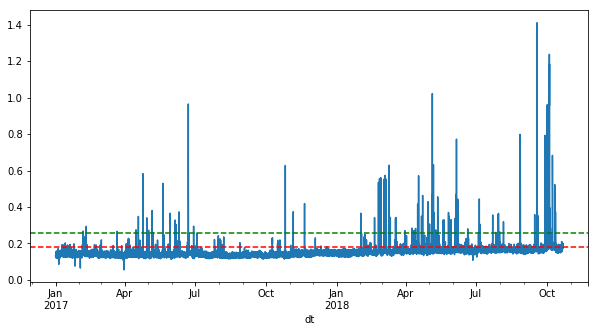

In [9]:
# Plot SP wholesale floating prices in blue
plt.figure(figsize=(10,5))
_ = wholesale_prices.set_index("dt").sort_index().wholesale_charge.plot()

# plot our best deal with a red line, sp tariff with green
_ = plt.axhline(y=best_deal, color='r', linestyle='--')
_ = plt.axhline(y=sp_tariff, color='g', linestyle='--')

## 2018 you scary!
It seems SP wholesale rate was way below our red and green lines for most of 2017. 2018 _really_ has alot of spikes, often crossing our best deal rate. But let's see how many times it became more expensive than our best deal?

In [10]:
periods_above_best_deal_rate = wholesale_prices[wholesale_prices.wholesale_charge > best_deal].count().values[0]
print("Number of periods where it crossed best_deal: {} ({}%)".format(periods_above_best_deal_rate, 
                                                                      periods_above_best_deal_rate/
                                                                          len(wholesale_prices)*100))

# period_2017 = wholesale_prices[wholesale_prices.year == 2017]
# periods_above_best_deal_rate_in_17 = period_2017[period_2017.wholesale_charge > best_deal].count().values[0]
# print("Number of periods where it crossed best_deal in 2017: {} ({}%)".format(periods_above_best_deal_rate_in_17, 
#                                                                               periods_above_best_deal_rate_in_17/
#                                                                                   len(period_2017)*100))

# period_2018 = wholesale_prices[wholesale_prices.year == 2018]
# periods_above_best_deal_rate_in_18 = period_2018[period_2018.wholesale_charge > best_deal].count().values[0]
# print("Number of periods where it crossed best_deal in 2018: {} ({}%)".format(periods_above_best_deal_rate_in_18, 
#                                                                               periods_above_best_deal_rate_in_18/
#                                                                                   len(period_2018)*100))

Number of periods where it crossed best_deal: 3156 (9.977238239757208%)


Turns out that it only crossed the best deal rate ~10% of the time. But the length of spikes seem really high and scary though...

### But _really_... should the spikes scare you?

To answer this question, we write a function to simulate my usage for every day based on uniform sampling. Getting averages is boring and doesnt reflect variability found in everyday usage and monthly bills. We can then run a simulation using my simulated usages to see how much we pay for the month and throughout the year. 

The idea is to see if we can still save in spite of the price spike, especially in 2018...

In [11]:
def get_simulated_usage(elect_usages, how="avg"):
    """ how={'avg','uniform'}
    """
    if how=="avg":
        df = pd.DataFrame(elect_usages.mean(axis=1), columns=["usage"])        
    elif how=="uniform":
        elect_usages["min_"] = elect_usages.min(axis=1)
        elect_usages["max_"] = elect_usages.max(axis=1)
        elect_usages["usage"] = elect_usages.apply(lambda x: np.random.uniform(x.min_, x.max_), axis=1)
        df = elect_usages.apply(lambda x: np.random.uniform(x.min_, x.max_), axis=1)
        df = pd.DataFrame(df, columns=["usage"])        
    return df

Here, I'm simulating daily usages for 30 days (~1 month).

In [12]:
simulated_usages = [get_simulated_usage(elect_usages, "uniform") for i in range(31)]

Here's a sample of what a 5 day usage look like:

/Users/plhb321c/python-anaconda/anaconda3/envs/drlnd/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


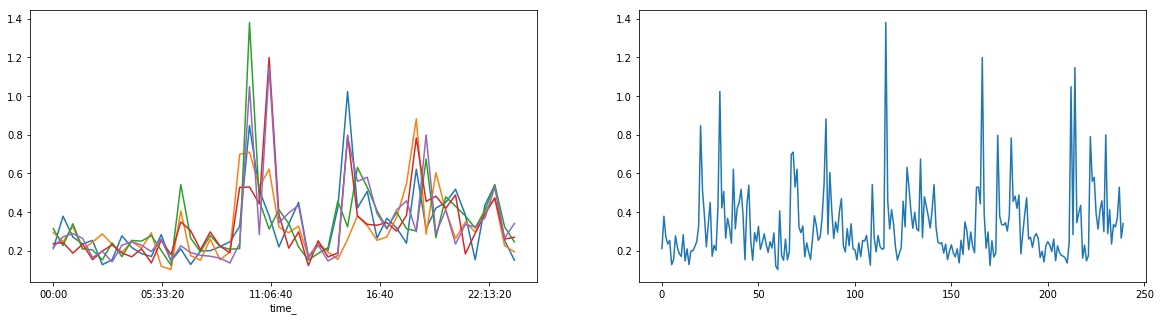

In [13]:
plt.figure(figsize=(20,5))

another_view = pd.DataFrame()
for n, usage in enumerate(simulated_usages[:5]):
    ax = plt.subplot(1,2,1)
    usage.plot(ax=ax,legend=None)
    another_view = another_view.append(usage)

ax = plt.subplot(1,2,2)
_ = another_view.reset_index().plot(ax=ax, legend=None)
    

And here's the bill using SP tariff and our best deal:

In [14]:
monthly_bill_tariff = np.sum([np.sum(i * sp_tariff).values[0] for i in simulated_usages])
monthly_bill_best_deal = np.sum([np.sum(i * best_deal).values[0] for i in simulated_usages])

print("SP tariff bill: ${}".format(monthly_bill_tariff))
print("Best deal bill: ${}".format(monthly_bill_best_deal))

SP tariff bill: $122.37885925249519
Best deal bill: $85.2196703857422


And now, lets write a function to calculate our bill using the wholesale price.

In [15]:
def calculate_daily_total_costs_using_wholesale(month, year, simulated_usages):    
    selected_wholesale_price = wholesale_prices[(wholesale_prices.month==month) & (wholesale_prices.year==year)]
    daily_total_costs = []
    for i in np.unique(selected_wholesale_price.day):
        usage = simulated_usages[i-1]
        day_prices = selected_wholesale_price[selected_wholesale_price.day == i]
        tmpdf_ = usage.join(day_prices.set_index("time_"))
        tmpdf_["cost"] = tmpdf_["usage"] * tmpdf_["wholesale_charge"]
        daily_total_costs.append(tmpdf_["cost"].values)    
    return daily_total_costs

~~remember to account for the meter reading charge!~~
It seems that since I have an AMI meter, SP told me I don't need to pay this charge! :D

In [16]:
# meter_reading_charge = 2.18
meter_reading_charge = 0

In [17]:
month = 1
year = 2018

wholesale_daily_total_costs = calculate_daily_total_costs_using_wholesale(month, year, simulated_usages)
monthly_sp_wholesale = np.sum([np.sum(i) for i in wholesale_daily_total_costs]) + meter_reading_charge

print("SP wholesale bill: ${}".format(monthly_sp_wholesale))

SP wholesale bill: $72.15252119446686


Whoa, did we just see some savings there? Not so fast!...

## Let's simulate our bills for the year!

In [18]:
from calendar import monthrange

cumulative_bill_best_deal = 0
cumulative_bill_sp_wholesale = 0
total_months = 0
no_of_months_saved = 0

year = 2017
for month in range(1,13): 
    no_of_days = monthrange(year, month)[1]
    simulated_usages = [get_simulated_usage(elect_usages, "uniform") for i in range(no_of_days+1)]
    monthly_bill_tariff = np.sum([np.sum(i * sp_tariff).values[0] for i in simulated_usages])
    monthly_bill_best_deal = np.sum([np.sum(i * best_deal).values[0] for i in simulated_usages])

    wholesale_daily_total_costs = calculate_daily_total_costs_using_wholesale(month, year, simulated_usages)
    monthly_bill_wholesale = np.sum([np.sum(i) for i in wholesale_daily_total_costs])
    monthly_bill_wholesale += meter_reading_charge
    
    print("For {} {}".format(datetime.strftime(datetime.strptime(str(month), "%m"), "%b"), year))
    print("="*30)
    print("SP Tariff bill: ${}".format(monthly_bill_tariff))
    print("Best deal bill: ${}".format(monthly_bill_best_deal))
    print("SP Wholesale Bill: ${}".format(monthly_bill_wholesale))    
    print("\n")

    cumulative_bill_best_deal += monthly_bill_best_deal
    cumulative_bill_sp_wholesale += monthly_bill_wholesale+meter_reading_charge    
    no_of_months_saved += 1 if monthly_bill_wholesale < monthly_bill_best_deal else 0
    total_months += 1

print("{} out of {} months saved!".format(no_of_months_saved, total_months))
print("I saved ${} in the year!".format(cumulative_bill_best_deal - cumulative_bill_sp_wholesale))

For Jan 2017
SP Tariff bill: $129.13938191381456
Best deal bill: $89.92742396632013
SP Wholesale Bill: $73.3233374784148


For Feb 2017
SP Tariff bill: $116.24258735339718
Best deal bill: $80.94661969845394
SP Wholesale Bill: $65.97784532103371


For Mar 2017
SP Tariff bill: $128.13418324896347
Best deal bill: $89.22744441581574
SP Wholesale Bill: $68.88240034917602


For Apr 2017
SP Tariff bill: $124.39928668070347
Best deal bill: $86.62661404024196
SP Wholesale Bill: $69.84597278335535


For May 2017
SP Tariff bill: $127.66373944375705
Best deal bill: $88.89984644456823
SP Wholesale Bill: $71.4178569842109


For Jun 2017
SP Tariff bill: $126.25506651559579
Best deal bill: $87.91890379358682
SP Wholesale Bill: $72.49080553666354


For Jul 2017
SP Tariff bill: $126.4255043286872
Best deal bill: $88.03758976877597
SP Wholesale Bill: $69.07594021597667


For Aug 2017
SP Tariff bill: $129.0126412329439
Best deal bill: $89.83916690040014
SP Wholesale Bill: $67.56998003326886


For Sep 2017

### Savings! savings! Oi! Oi! Oi! 

But of course 2017 is not representative of current prices. Let's check out 2018...

In [19]:
from calendar import monthrange

cumulative_bill_best_deal = 0
cumulative_bill_sp_wholesale = 0
total_months = 0
no_of_months_saved = 0

year = 2018
for month in range(1,10): 
    no_of_days = monthrange(year, month)[1]
    simulated_usages = [get_simulated_usage(elect_usages, "uniform") for i in range(no_of_days+1)]
    monthly_bill_tariff = np.sum([np.sum(i * sp_tariff).values[0] for i in simulated_usages])
    monthly_bill_best_deal = np.sum([np.sum(i * best_deal).values[0] for i in simulated_usages])

    wholesale_daily_total_costs = calculate_daily_total_costs_using_wholesale(month, year, simulated_usages)
    monthly_bill_wholesale = np.sum([np.sum(i) for i in wholesale_daily_total_costs])
    monthly_bill_wholesale += meter_reading_charge
    
    print("For {} {}".format(datetime.strftime(datetime.strptime(str(month), "%m"), "%b"), year))
    print("="*30)
    print("SP Tariff bill: ${}".format(monthly_bill_tariff))
    print("Best deal bill: ${}".format(monthly_bill_best_deal))
    print("SP Wholesale Bill: ${}".format(monthly_bill_wholesale))    
    print("\n")

    cumulative_bill_best_deal += monthly_bill_best_deal
    cumulative_bill_sp_wholesale += monthly_bill_wholesale   
    no_of_months_saved += 1 if monthly_bill_wholesale < monthly_bill_best_deal else 0
    total_months += 1

print("{} out of {} months saved!".format(no_of_months_saved, total_months))
print("I saved ${} in the year!".format(cumulative_bill_best_deal - cumulative_bill_sp_wholesale))

For Jan 2018
SP Tariff bill: $128.0920482230012
Best deal bill: $89.19810329394119
SP Wholesale Bill: $73.17373019873878


For Feb 2018
SP Tariff bill: $116.98035681839372
Best deal bill: $81.46037240878076
SP Wholesale Bill: $72.8022950729253


For Mar 2018
SP Tariff bill: $126.55351879424833
Best deal bill: $88.12673384665317
SP Wholesale Bill: $81.81829243055479


For Apr 2018
SP Tariff bill: $122.4517726598669
Best deal bill: $85.27044432317608
SP Wholesale Bill: $78.88202423791982


For May 2018
SP Tariff bill: $128.36853308648614
Best deal bill: $89.39063613071343
SP Wholesale Bill: $88.02028195263048


For Jun 2018
SP Tariff bill: $125.87583196937291
Best deal bill: $87.654820248231
SP Wholesale Bill: $84.57849306988005


For Jul 2018
SP Tariff bill: $128.37037784362548
Best deal bill: $89.39192074470898
SP Wholesale Bill: $84.62352104519363


For Aug 2018
SP Tariff bill: $127.20440716562128
Best deal bill: $88.57998608977034
SP Wholesale Bill: $85.78537308176523


For Sep 2018


### Lets run this simulation a few more times to ensure this is not a fluke!
Wrap up what I had above as a function...

In [20]:
def run_simulation(stop_month_at=12, year=2018):
    cumulative_bill_best_deal = 0
    cumulative_bill_sp_wholesale = 0
    total_months = 0
    no_of_months_saved = 0
    year = year

    for month in range(1,stop_month_at+1): 
        no_of_days = monthrange(year, month)[1]
        simulated_usages = [get_simulated_usage(elect_usages, "uniform") for i in range(no_of_days+1)]
        
        monthly_bill_tariff = np.sum([np.sum(i * sp_tariff).values[0] for i in simulated_usages])
        monthly_bill_best_deal = np.sum([np.sum(i * best_deal).values[0] for i in simulated_usages])

        wholesale_daily_total_costs = calculate_daily_total_costs_using_wholesale(month, year, simulated_usages)
        monthly_bill_wholesale = np.sum([np.sum(i) for i in wholesale_daily_total_costs])
        monthly_bill_wholesale += meter_reading_charge

        cumulative_bill_best_deal += monthly_bill_best_deal
        cumulative_bill_sp_wholesale += monthly_bill_wholesale 
        no_of_months_saved += 1 if monthly_bill_wholesale < monthly_bill_best_deal else 0
        total_months += 1

    print("{} out of {} months saved!".format(no_of_months_saved, total_months))
    print("I saved ${} in the year!\n".format(cumulative_bill_best_deal - cumulative_bill_sp_wholesale))

...and run it!

In [21]:
no_of_episodes = 15
year = 2018
no_of_months = 9

for i in range(no_of_episodes):
    print("Simulation #{}".format(i+1))
    run_simulation(no_of_months, year)

Simulation #1
9 out of 9 months saved!
I saved $51.92145739183127 in the year!

Simulation #2
8 out of 9 months saved!
I saved $50.50467529948992 in the year!

Simulation #3
9 out of 9 months saved!
I saved $49.95844391696153 in the year!

Simulation #4
9 out of 9 months saved!
I saved $49.3215132378856 in the year!

Simulation #5
9 out of 9 months saved!
I saved $51.09188498489027 in the year!

Simulation #6
8 out of 9 months saved!
I saved $50.08057598902701 in the year!

Simulation #7
8 out of 9 months saved!
I saved $49.68288163130023 in the year!

Simulation #8
9 out of 9 months saved!
I saved $48.86053094668955 in the year!

Simulation #9
9 out of 9 months saved!
I saved $51.29422976568708 in the year!

Simulation #10
9 out of 9 months saved!
I saved $51.11576445533683 in the year!

Simulation #11
8 out of 9 months saved!
I saved $49.068499826878906 in the year!

Simulation #12
8 out of 9 months saved!
I saved $49.25891005978781 in the year!

Simulation #13
9 out of 9 months save

### ...good enough for me to switch!

## Thoughts & Conclusion (at this time of writing!)
* If you have usage like mine, switch to SP Wholesale. Sure, some months you lose but you'll realize more savings in the long-run.
* Even taking into account spikes, we can still realize savings from the best deal in the market.
* No brainer when taking into account no contract and no termination fees!
* Realize even more savings by taking advantage of low-cost periods for high-energy consumption tasks like using the dryer or ironing. For my case, I switch from using electrical cooker to more conventional gas.
* Write a service in IFTTT to tell you when there is a spike. Example below.
* A colleague observed that October 2018 may be a start of rising oil/energy prices and that the wholesale price might most of the time cross the best deal plan. I share his sentiments. However, this will also mean that retailers of this plan will also be in the red since their margins are also very low - this will force them to come up with the same plan with a higher price; and I believe this price will still be higher than the wholesale price. The winner in this case are consumers who bought the best deal plan at the beginning.

In [22]:
def _fetch_current_emc_prices():
    import urllib.request
    import json
    url = "http://www.emcsg.com/ChartServer/blue/ticker"
    req = urllib.request.Request(url=url, method='GET')
    res = urllib.request.urlopen(req)
    res_body = res.read()
    payload = json.loads(res_body.decode("utf-8"))
    return payload


def fetch_current_usep():
    current_prices = _fetch_current_emc_prices()
    date_ = current_prices['Date']
    period = current_prices['Period']
    label = current_prices['Sections'][0]['SectionData'][0]['Label']
    value = current_prices['Sections'][0]['SectionData'][0]['Value']    
    return date_, period, label, value

In [ ]:
from collections import deque
import time

no_of_latest_records_to_keep = 48
past_usep_prices = deque(maxlen=no_of_latest_records_to_keep)
std_dev_threshold = 2.5

while True:
    current_usep = fetch_current_usep()[3]
    if len(past_usep_prices) > 0:
        if np.std([past_usep_prices[-1], current_usep]) >= std_dev_threshold or 
           np.std([np.mean(past_usep_prices),current_usep]) >= std_dev_threshold:
                print("USEP Spike! Switch off appliances now!")
    past_usep_prices.append(current_usep)
    time.sleep(60*30) # 30 mins

_&copy; Luqman Hakim A Hadi, Nov 2018_